In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

---

# Latent Semantic Analysis 실습 2

(예제) 다음과 같이 document와 query가 주어졌다.

$d_1$ : "Machine learning is super fun"

$d_2$ : "Python is super, super cool"

$d_3$ : "Statistics is cool, too"

$d_4$ : "Data science is fun"

$d_5$ : "Python is great for machine learning"

$d_6$ : "I like football"
    
$d_7$ : "Football is great to watch"

$query$ : "machine learning python"

In [3]:
# Matrix를 생성하기 위하여, index의 고정이 필요하고, 이를 위해서 순서를 정확히 보장하기 위해 OrderDict을 사용한다.
from collections import OrderedDict

# Corpus를 생성한다.
corpus = OrderedDict(
    {
        'cool':0, 
        'data':1,
        'football':2,
        'fun':3,
        'great':4,
        'learning':5,
        'like':6,
        'machine':7,
        'python':8,
        'science':9,
        'statistics':10,
        'super':11,
        'watch':12
    }
)

In [4]:
d1 = "Machine learning is super fun"
d2 = "Python is super, super cool"
d3 = "Statistics is cool, too"
d4 = "Data science is fun"
d5 = "Python is great for machine learning"
d6 = "I like football"
d7 = "Football is great to watch"

docs = [d1, d2, d3, d4, d5, d6, d7]

## 1. Document-Word matrix 생성

### 1.1. 전처리 (Python 진영에서는 전문적인 형태소분석기 konlpy를 사용하면 된다.)

In [5]:
# 각 문서를 빈 여백을 기준으로 나눈다.
d1_tokens = d1.split(' ')
d1_tokens

['Machine', 'learning', 'is', 'super', 'fun']

In [6]:
# 대소문자의 구분을 없앤다.
d1_tokens = map(str.lower, d1_tokens)  # 또는 [s.lower for s in d1_tokens]를 사용
d1_tokens = list(d1_tokens)
d1_tokens

['machine', 'learning', 'is', 'super', 'fun']

In [7]:
import re

In [8]:
# '-'를 제외한 구두점만 제거한다. (아주 간단하게)
d1_tokens = [re.sub(r'[^a-zA-Z0-9-]', '', token) for token in d1_tokens]
d1_tokens

['machine', 'learning', 'is', 'super', 'fun']

---

(Advanced)

In [9]:
# 구두점을 제거하는 방법은 다음과 같이 하면 된다.
import string
print(string.punctuation)

s = 'test-string,wow.good!'
translator=str.maketrans('','',string.punctuation)
s.translate(translator)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


'teststringwowgood'

In [10]:
# a-z and A-Z and 0-9 and -를 제외한(^) 단어는 empty string과 교체한다.
re.sub(r'[^a-zA-Z0-9-]', '','asd-')

'asd-'

---

In [11]:
# 함수로 정의한다.
def parse_document(doc):
    tokens = doc.split(' ')
    tokens = map(str.lower, tokens)
    tokens = list(tokens)
    tokens = [re.sub(r'[^a-zA-Z0-9-]', '', token) for token in tokens]
    
    return tokens

In [12]:
# 사실 이 과정에서, 과거형은 현재형으로, 축약형 that's는 that is로 변경해주는 등
# "형태소 분석" 과정이 필요하나 그것은 NLP 전처리 과정에 속함으로 우선은 여기까지만 작업한다.
d2_tokens = parse_document(d2)
d3_tokens = parse_document(d3)
d4_tokens = parse_document(d4)
d5_tokens = parse_document(d5)
d6_tokens = parse_document(d6)
d7_tokens = parse_document(d7)

print(d1_tokens)
print(d2_tokens)
print(d3_tokens)
print(d4_tokens)
print(d5_tokens)
print(d6_tokens)
print(d7_tokens)

['machine', 'learning', 'is', 'super', 'fun']
['python', 'is', 'super', 'super', 'cool']
['statistics', 'is', 'cool', 'too']
['data', 'science', 'is', 'fun']
['python', 'is', 'great', 'for', 'machine', 'learning']
['i', 'like', 'football']
['football', 'is', 'great', 'to', 'watch']


### 1.2. Document vector를 생성한다.

In [13]:
print(d1_tokens)

['machine', 'learning', 'is', 'super', 'fun']


In [14]:
# 먼저 corpus내의 iterator 내용을 확인하자.
for v, i in corpus.items():
    print(v, i)

cool 0
data 1
football 2
fun 3
great 4
learning 5
like 6
machine 7
python 8
science 9
statistics 10
super 11
watch 12


#### <font color=red>Document를 구성하는 vector의 길이는 corpus의 길이와 같다.</font>

In [15]:
corpus.values()

odict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

- 첫번째 문장 `Machine learning is super fun`은,

- 전처리 후 `'machine', 'learning', 'is', 'super', 'fun'` tokens가 되며,

- 전체 corpus을 entry로 가진 vector `(cool:없음) (data:없음) (football:없음) fun (great:없음) learning (like:없음) machine (python:없음) (science:없음) (statistics:없음) super (watch:없음)`에 대응되고,

- 최종적으로 document vector `0 0 0 1 0 1 0 1 0 0 0 1 0`에 대응된다.

In [16]:
# d1 vector를 생성해보자.
d1_vec = []
for v, i in corpus.items():
    if v in d1_tokens:
        d1_vec.append(1)
    else:
        d1_vec.append(0)
d1_vec

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]

In [17]:
# Document vector를 생성하는 코드를 함수로 바꿔보자.
def get_doc_vector(tokens):
    doc_vec = [1 if v in tokens else 0 for v, i in corpus.items()]
    return doc_vec

In [18]:
d2_vec = get_doc_vector(d2_tokens)
d3_vec = get_doc_vector(d3_tokens)
d4_vec = get_doc_vector(d4_tokens)
d5_vec = get_doc_vector(d5_tokens)
d6_vec = get_doc_vector(d6_tokens)
d7_vec = get_doc_vector(d7_tokens)

print(d1_vec)
print(d2_vec)
print(d3_vec)
print(d4_vec)
print(d5_vec)
print(d6_vec)
print(d7_vec)

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


### 1.3. Document-Word matrix를 생성한다.

In [19]:
# 최종 matrix Word-Document matrix
A = np.array([d1_vec, d2_vec, d3_vec, d4_vec, d5_vec, d6_vec, d7_vec])
A

array([[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])

## 2. Doc-Doc matrix 와 Word-Word matrix를 생성한다.

### 2.1. Doc-Doc matrix $AA^T$ :  문서 $i$와 문서 $j$가 $b$개의 공통 단어를 가지고 있으면 $B[i, j]=b$

In [20]:
doc_mat = np.dot(A, A.T)
doc_mat

array([[4, 1, 0, 1, 2, 0, 0],
       [1, 3, 1, 0, 1, 0, 0],
       [0, 1, 2, 0, 0, 0, 0],
       [1, 0, 0, 3, 0, 0, 0],
       [2, 1, 0, 0, 4, 0, 1],
       [0, 0, 0, 0, 0, 2, 1],
       [0, 0, 0, 0, 1, 1, 3]])

### 2.2. Word-Word matrix $A^TA$ : 단어 $i$와 단어 $j$가 문서 $c$개 에서 함께 발생했으면 $C[i,j]=c$

In [21]:
word_mat = np.dot(A.T, A)
word_mat

array([[2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])

## 3. SVD(Singular Value Decomposition)

### $$A=U \Sigma V^T$$

In [22]:
U, sig, V_T = np.linalg.svd(A)

### 3.1. $U$의 컬럼은 $AA^T$의 고유벡터들이다.  즉 Doc-Doc matrix 데이터를 생성하는 축들이다.

In [23]:
U

array([[-0.63555233,  0.3116475 , -0.23588417,  0.0923833 , -0.51003069,
         0.29231986, -0.29864837],
       [-0.35219853,  0.13826479,  0.61288984, -0.36051167, -0.04467366,
        -0.56373943, -0.17730917],
       [-0.07303416,  0.07324226,  0.43497297, -0.43325945,  0.1676411 ,
         0.73984157,  0.19213866],
       [-0.16627132,  0.35104399, -0.57669202, -0.55020151,  0.4027139 ,
        -0.16590483,  0.155318  ],
       [-0.63765049, -0.26214197,  0.05160136,  0.40140898,  0.39896807,
        -0.03886768,  0.44744312],
       [-0.03657726, -0.38783282, -0.12179755, -0.3522012 , -0.60221382,
        -0.113457  ,  0.57778327],
       [-0.17638947, -0.73214047, -0.17161637, -0.29306375,  0.16048032,
         0.08645119, -0.53318928]])

> $AA^T$ 의 eigenvector (컬럼들)

In [24]:
# np.linalg.eig(np.dot(A, A.T))

### 3.2. $V$의 컬럼은 $AA^T$의 고유벡터들이다. 즉 Word-Word matrix 데이터를 생성하는 축들이다.

In [25]:
# V의 각 컬럼은 A^T*A의 eigenvector 이다.
V_T.T

array([[-0.16280159,  0.10726903,  0.56753028, -0.47167366,  0.09339555,
         0.15827037,  0.01428834, -0.11369133, -0.20704032,  0.03298642,
        -0.46399237, -0.33237781,  0.02832841],
       [-0.06365747,  0.17803733, -0.31234068, -0.32694004,  0.30586704,
        -0.14910562,  0.14965023,  0.36329084, -0.49577965, -0.35164399,
         0.26687418, -0.19166032, -0.11061159],
       [-0.08153494, -0.56801159, -0.15891516, -0.38342851, -0.335503  ,
        -0.02427125,  0.04296669,  0.21060964,  0.23009486,  0.06441144,
        -0.04761734, -0.16005546, -0.50409511],
       [-0.30698056,  0.33609413, -0.4400973 , -0.27204415, -0.08150866,
         0.11361448, -0.13810005, -0.30264492,  0.40962447, -0.41313829,
        -0.22319577,  0.043474  ,  0.06863482],
       [-0.31165761, -0.50426555, -0.06500102,  0.06438076,  0.42490916,
         0.04276529, -0.08261717, -0.31394715, -0.29811439, -0.13523936,
        -0.1814318 ,  0.44723235, -0.11115103],
       [-0.48744948,  0.025107

> $A^TA$의 eigenvector (컬럼들)

In [26]:
# np.linalg.eig(np.dot(A.T, A))

## 4. Word vector와 Document vector 생성하기

Word vector와 document vector를 생성할 때, 선택하는 singular value의 수가 중요하다. 2차원으로 보여주기 위해 $k=2$로 표현하자.

### 4.1. Words Vectors

In [27]:
word_eigen_vec = V_T.T[:, :2]

In [28]:
# Word-Word matrix의 eigenvectors
word_eigen_vec

array([[-0.16280159,  0.10726903],
       [-0.06365747,  0.17803733],
       [-0.08153494, -0.56801159],
       [-0.30698056,  0.33609413],
       [-0.31165761, -0.50426555],
       [-0.48744948,  0.02510749],
       [-0.01400371, -0.19669535],
       [-0.48744948,  0.02510749],
       [-0.37896663, -0.06282621],
       [-0.06365747,  0.17803733],
       [-0.02796134,  0.03714593],
       [-0.37816335,  0.2281799 ],
       [-0.06753123, -0.37131624]])

In [29]:
# Singular value
sig

array([2.6119688 , 1.97174373, 1.84635579, 1.68288201, 1.31663057,
       1.11266654, 1.03787339])

$$\text{word vector} = \Sigma V^T$$

In [30]:
word_vec = np.dot(np.diag(sig[:2]), word_eigen_vec.T)

In [31]:
# Sigular value가 weight로 사용된 word vector
word_vec.T

array([[-0.42523269,  0.21150705],
       [-0.16627132,  0.35104399],
       [-0.21296672, -1.11997329],
       [-0.80182365,  0.66269149],
       [-0.81403996, -0.99428243],
       [-1.27320282,  0.04950553],
       [-0.03657726, -0.38783282],
       [-1.27320282,  0.04950553],
       [-0.98984902, -0.12387718],
       [-0.16627132,  0.35104399],
       [-0.07303416,  0.07324226],
       [-0.98775086,  0.44991228],
       [-0.17638947, -0.73214047]])

In [32]:
# Plotting 을 위해 다음과 같이 x축 y축을 구분한다.
# x 축
w_x = word_vec[0]
# y 축
w_y = word_vec[1]
# Words를 plotting에 나타내기 위해서
words = corpus.keys()
words

odict_keys(['cool', 'data', 'football', 'fun', 'great', 'learning', 'like', 'machine', 'python', 'science', 'statistics', 'super', 'watch'])

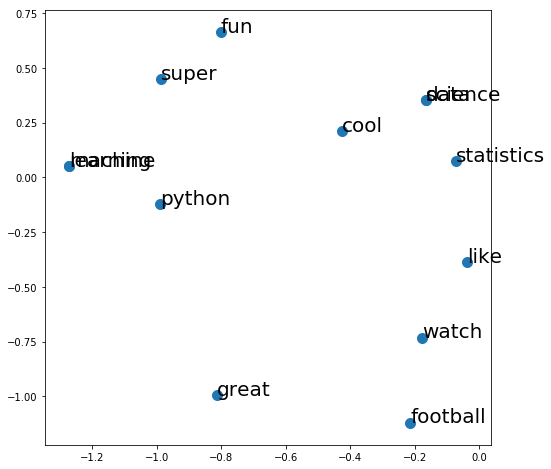

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 8)

fig, ax = plt.subplots()

# Scatter
ax.scatter(w_x, w_y, s=100)

# Scatter에 라벨링을 한다.
for i, txt in enumerate(words):
    ax.annotate(txt, (w_x[i], w_y[i]), fontsize=20)  # free와 live가 겹쳐지는 위치

### 4.2. Document Vectors

In [34]:
doc_eigen_vec = U[:, :2]

In [35]:
# Doc-Doc matrix의 eigenvectors
doc_eigen_vec

array([[-0.63555233,  0.3116475 ],
       [-0.35219853,  0.13826479],
       [-0.07303416,  0.07324226],
       [-0.16627132,  0.35104399],
       [-0.63765049, -0.26214197],
       [-0.03657726, -0.38783282],
       [-0.17638947, -0.73214047]])

In [36]:
# Singular value
sig

array([2.6119688 , 1.97174373, 1.84635579, 1.68288201, 1.31663057,
       1.11266654, 1.03787339])

In [37]:
# Sigular value가 weight로 사용된 doc vector
doc_vec = np.dot(doc_eigen_vec, np.diag(sig[:2]))

In [38]:
doc_vec

array([[-1.66004286,  0.614489  ],
       [-0.91993157,  0.27262272],
       [-0.19076294,  0.14441497],
       [-0.43429549,  0.69216879],
       [-1.6655232 , -0.51687678],
       [-0.09553865, -0.76470694],
       [-0.46072378, -1.44359338]])

In [39]:
# Plotting을 위해서 다음과 같이 나눈다.
doc_x = doc_vec[:, 0]
doc_y = doc_vec[:, 1]

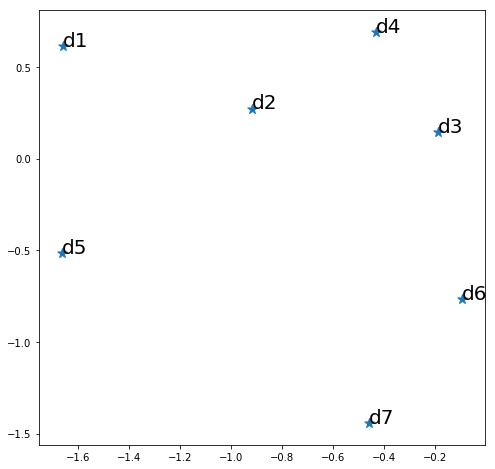

In [58]:
fig, ax = plt.subplots()

# Scatter
ax.scatter(doc_x, doc_y, marker='*', s=100)

# Scatter에 라벨링을 한다.
for i, txt in enumerate(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']):
    ax.annotate(txt, (doc_x[i], doc_y[i]), fontsize=20)

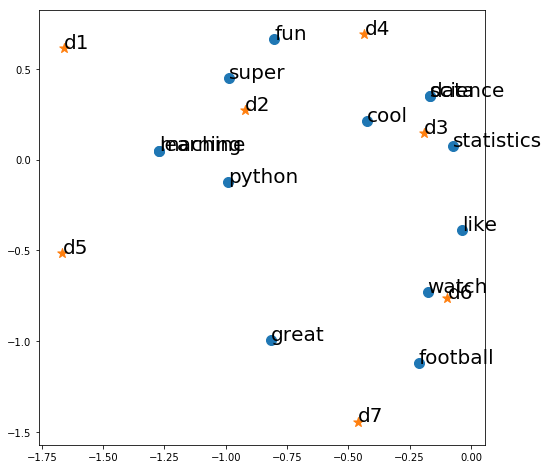

In [59]:
# Document와 word를 함께 나타내보겠다.
fig, ax = plt.subplots()
ax.scatter(w_x, w_y, s=100)
for i, txt in enumerate(words):
    ax.annotate(txt, (w_x[i], w_y[i]), fontsize=20)
    
ax.scatter(doc_x, doc_y, marker='*', s=100)
for i, txt in enumerate(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']):
    ax.annotate(txt, (doc_x[i], doc_y[i]), fontsize=20)

## 5. Query, document distance 구하기

### 5.1. Query

In [42]:
# Query : die, dagger
q1 = word_vec[:, 7]
print('machine', q1)

q2 = word_vec[:, 8]
print('python', q2)

q3 = word_vec[:, 5]
print('learning', q3)

machine [-1.27320282  0.04950553]
python [-0.98984902 -0.12387718]
learning [-1.27320282  0.04950553]


In [43]:
query = (q1 + q2 + q3) / 2
print('machine and die :', query)

machine and die : [-1.76812734 -0.01243306]


### 5.2. Query와 document의 거리 : Word embedding 공간에서는 cosine similarity를 사용
$$\text{Cosine Similarity} = \frac{d_i q}{|d_i| |q|}$$

In [44]:
def get_consine_similarity(doc, query):
    dot_prod = np.dot(doc, query)
    len_doc = np.sqrt(sum(doc ** 2))
    len_query = np.sqrt(sum(query ** 2))
    
    return dot_prod / (len_doc * len_query)

In [45]:
result = {}
for idx, doc in zip(docs, doc_vec):
    result[get_consine_similarity(doc, query)] = idx

In [46]:
result

{0.13094550141614597: 'I like football',
 0.3107328592424753: 'Football is great to watch',
 0.525515997829132: 'Data science is fun',
 0.79303424462753: 'Statistics is cool, too',
 0.935347449754247: 'Machine learning is super fun',
 0.9567621655734275: 'Python is super, super cool',
 0.9571262278922464: 'Python is great for machine learning'}

### 5.3. 최종 결과

In [47]:
import operator

# 최종결과를 sorting하라!
sorted(result.items(), key=operator.itemgetter(0), reverse=True)

[(0.9571262278922464, 'Python is great for machine learning'),
 (0.9567621655734275, 'Python is super, super cool'),
 (0.935347449754247, 'Machine learning is super fun'),
 (0.79303424462753, 'Statistics is cool, too'),
 (0.525515997829132, 'Data science is fun'),
 (0.3107328592424753, 'Football is great to watch'),
 (0.13094550141614597, 'I like football')]

Text(-1.76813,-0.0124331,'query')

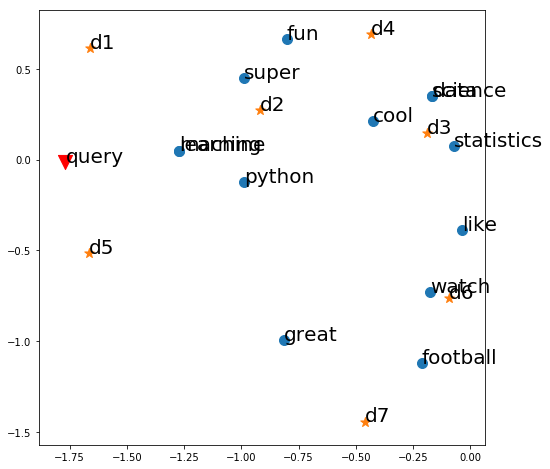

In [60]:
fig, ax = plt.subplots()
ax.scatter(w_x, w_y, s=100)
for i, txt in enumerate(words):
    ax.annotate(txt, (w_x[i], w_y[i]), fontsize=20)
    
ax.scatter(doc_x, doc_y, marker='*', s=100)
for i, txt in enumerate(['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']):
    ax.annotate(txt, (doc_x[i], doc_y[i]), fontsize=20)
    
ax.scatter(query[0], query[1], marker='v', s=200, color='red')
ax.annotate('query', (query[0], query[1]), fontsize=20)

---